# Evaluación de PC-SMOTE con Grid Search en el dataset Shuttle (Generación de caso base y datasets aumentados)


In [9]:
# lo que hace es modificar la lista de rutas de búsqueda de módulos de Python (sys.path) para incluir las carpetas ../scripts y ../datasets como ubicaciones adicionales donde Python puede buscar módulos o paquetes cuando hacés un import.
import sys
sys.path.append("../scripts")
sys.path.append("../datasets")

## Importación de módulos y librerías necesarias


In [10]:
# --- Módulos propios del proyecto ---
from cargar_dataset import cargar_dataset                      # Función para cargar datasets según configuración
from config_datasets import config_datasets                    # Diccionario de configuración de datasets
from evaluacion import evaluar_sampler_holdout                 # Evaluación de sobremuestreo con partición hold-out
from custom_samplers import PCSMOTEWrapper                     # Wrapper personalizado para la técnica PCSMOTE
from pc_smote import PCSMOTE                                   # Implementación principal de PCSMOTE

# --- Librerías estándar de Python ---
from datetime import datetime, timedelta                       # Manejo de fechas y tiempos
from itertools import product                                  # Generación de combinaciones de parámetros
import gc, os, time                                                      # Operaciones con el sistema de archivos

# --- Librerías científicas ---
import numpy as np                                              # Operaciones numéricas y algebra lineal
import pandas as pd                                             # Manipulación y análisis de datos tabulares
from scipy.stats import uniform                                 # Distribuciones para búsqueda de hiperparámetros

# --- Scikit-learn: preprocesamiento ---
from sklearn.preprocessing import LabelEncoder, StandardScaler # Codificación de etiquetas y escalado de datos
from sklearn.pipeline import make_pipeline, Pipeline            # Creación de pipelines de procesamiento y modelado

# --- Scikit-learn: división y validación ---
from sklearn.model_selection import (
    train_test_split,                                           # División de datos en train/test
    StratifiedKFold,                                            # Validación cruzada estratificada
    RandomizedSearchCV                                          # Búsqueda aleatoria de hiperparámetros
)

# --- Scikit-learn: reducción de dimensionalidad ---
from sklearn.decomposition import PCA                           # Análisis de Componentes Principales

# --- Scikit-learn: métricas ---
from sklearn.metrics import (
    f1_score,                                                   # Métrica F1-Score    
    recall_score, 
    roc_auc_score,
    balanced_accuracy_score,                                     # Precisión balanceada
    matthews_corrcoef,                                           # Coeficiente MCC
    cohen_kappa_score,                                           # Kappa de Cohen
    make_scorer                                            
)

import matplotlib.pyplot as plt  # para el gráfico

# --- Scikit-learn: clasificadores ---
from sklearn.ensemble import RandomForestClassifier             # Clasificador Random Forest
from sklearn.linear_model import LogisticRegression             # Regresión logística
from sklearn.svm import SVC                                      # Máquinas de Vectores de Soporte (SVM)
from scipy.stats import loguniform, randint, uniform

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Evitar sobre-suscripción de CPU (BLAS/OpenMP)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

'1'

### Evaluación de modelos con validación cruzada estratificada

Para evaluar el rendimiento de los modelos de clasificación sobre los datasets previamente balanceados, se utilizó validación cruzada estratificada de 5 particiones (Stratified K-Fold con *k=5*). Este método garantiza que en cada fold de entrenamiento y validación se preserve la proporción original de clases, lo cual es especialmente importante en tareas de clasificación multiclase con datasets balanceados artificialmente.

Durante el proceso, cada modelo es entrenado y evaluado cinco veces, cada vez usando un subconjunto distinto como conjunto de prueba y el resto como conjunto de entrenamiento. Las métricas calculadas en cada iteración (F1-score macro, balanced accuracy, MCC y kappa de Cohen) se promedian para obtener un valor representativo y del rendimiento general del modelo sobre ese dataset aumentado.

Este enfoque evita sobreajuste y proporciona una evaluación más confiable que una simple división train/test, permitiendo comparar de forma justa distintas configuraciones de sobremuestreo y modelos de clasificación.


In [11]:
# -----------------------------
# Modelos base + espacios (afinados)
# -----------------------------
modelos = {
    "SVM": {
        "pipeline": Pipeline([
            ('classifier', SVC(random_state=42, probability=True, max_iter=5000, cache_size=400))
        ]),
        "param_distributions": {
            'classifier__kernel': ['linear', 'rbf'],          # sin poly/sigmoid
            'classifier__C': loguniform(1e-3, 1e2),
            'classifier__gamma': loguniform(1e-4, 1e0),       # ignorado con 'linear'
            'classifier__shrinking': [True, False],
            'classifier__class_weight': [None, 'balanced']
        }
    },

    "LogisticRegression": {
        "pipeline": Pipeline([
            ('classifier', LogisticRegression(max_iter=5000, random_state=42))
        ]),
        "param_distributions": {
            'classifier__solver': ['saga', 'lbfgs'],
            'classifier__penalty': ['l2'],
            'classifier__C': loguniform(1e-4, 1e2),
            'classifier__fit_intercept': [True, False],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__tol': loguniform(1e-5, 1e-3),
            'classifier__dual': [False]
        }
    },

    "RandomForest": {
        "pipeline": Pipeline([('classifier', RandomForestClassifier(
            random_state=42, n_jobs=1, bootstrap=True, oob_score=False
        ))]),
        "param_distributions": {
            'classifier__n_estimators': randint(200, 601),
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 10, 20, 40],
            'classifier__min_samples_split': randint(2, 21),
            'classifier__min_samples_leaf': randint(1, 11),
            'classifier__max_features': ['sqrt', 'log2'],
            'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
            'classifier__ccp_alpha': uniform(0.0, 0.01)
        }
    }
}

# Orden: primero lo más rápido/estable
orden_modelos = ["LogisticRegression", "RandomForest", "SVM"]

# -----------------------------
# Rutas
# -----------------------------
ruta_aug  = "../datasets/datasets_aumentados_scaled/"
ruta_base = "../datasets/datasets_aumentados/base/" 
dir_out   = "../resultados/resultados_scaled/"
os.makedirs(dir_out, exist_ok=True)

# -----------------------------
# Listado de pares train/test
# -----------------------------
def listar_pares(ruta, tipo):
    pares = []
    if not os.path.isdir(ruta):
        return pares
    for f in os.listdir(ruta):
        if not (f.endswith("_train.csv") and os.path.isfile(os.path.join(ruta, f))):
            continue
        path_train = os.path.join(ruta, f)
        path_test  = os.path.join(ruta, f.replace("_train.csv", "_test.csv"))
        if not os.path.isfile(path_test):
            print(f"⚠️ Falta el test para: {f} -> esperado: {os.path.basename(path_test)}")
            continue
        pares.append({
            "tipo": tipo,
            "nombre_train": f,
            "path_train": path_train,
            "path_test": path_test
        })
    return pares

pares = listar_pares(ruta_aug, "aumentado") + listar_pares(ruta_base, "base")
pares = sorted(pares, key=lambda x: (x["tipo"], x["nombre_train"]))
total_pares = len(pares)

# -----------------------------
# Métricas CV
# -----------------------------
# -----------------------------
# Métricas CV
# -----------------------------
def gmean_macro(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None, zero_division=0)
    recalls = np.clip(recalls, 1e-12, 1.0)
    return float(np.prod(recalls) ** (1.0 / len(recalls)))

gmean_macro_scorer = make_scorer(gmean_macro)

scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
    'mcc': make_scorer(matthews_corrcoef),
    'cohen_kappa': make_scorer(cohen_kappa_score),
    'gmean_macro': gmean_macro_scorer
}

# -----------------------------
# Resumible: claves ya calculadas
# -----------------------------
def cargar_claves_existentes():
    done = {m: set() for m in modelos}
    for m in modelos:
        p = os.path.join(dir_out, f"resultados_{m}.csv")
        if os.path.exists(p):
            try:
                df_prev = pd.read_csv(p)
                for _, r in df_prev.iterrows():
                    done[m].add((
                        str(r.get('dataset')), str(r.get('tipo', '')),
                        str(r.get('tecnica')), str(r.get('densidad')),
                        str(r.get('riesgo')), str(r.get('pureza'))
                    ))
            except Exception:
                pass
    return done

ya_hechos = cargar_claves_existentes()
resultados_por_modelo = {nombre: [] for nombre in modelos}

# -----------------------------
# Helper de carga (float32)
# -----------------------------
def cargar_xy(path_csv):
    df = pd.read_csv(path_csv)
    if "target" in df.columns:
        X = df.drop(columns=["target"]).to_numpy(dtype=np.float32, copy=False)
        y = df["target"].to_numpy()
    else:
        X = df.iloc[:, :-1].to_numpy(dtype=np.float32, copy=False)
        y = df.iloc[:, -1].to_numpy()
    return X, y

# =============================
# Loop principal
# =============================
for idx_par, item in enumerate(pares, start=1):
    archivo_train = item["nombre_train"]
    ruta_train = item["path_train"]; ruta_test = item["path_test"]
    tipo = item["tipo"]

    # Parseo nombre
    nombre = archivo_train.replace(".csv", "")
    partes = nombre.split("_")
    if tipo == "aumentado":
        if len(partes) < 6:
            print(f"⚠️ Nombre inválido/incompleto (aumentado): {archivo_train}")
            continue
        tecnica = partes[0]; nombre_dataset = partes[1]
        densidad = partes[2][1:]; riesgo = partes[3][1:]; pureza = partes[4][1:]
    else:
        tecnica = "base"; nombre_dataset = nombre.replace("_train", "")
        densidad = riesgo = pureza = "NA"

    print(f"\n📂 ({idx_par}/{total_pares}) Par: {archivo_train}  (tipo: {tipo})")
    print(f"🔎 Técnica: {tecnica} | Dataset: {nombre_dataset} | Densidad: {densidad} | Riesgo: {riesgo} | Pureza: {pureza}")

    # Carga de datos
    try:
        X_train, y_train = cargar_xy(ruta_train)
        X_test,  y_test  = cargar_xy(ruta_test)
    except Exception as e:
        print(f"❌ Error al leer train/test ({archivo_train}): {e}")
        continue

    n_samples, n_features = X_train.shape
    es_grande = (n_samples >= 10000) or (nombre_dataset.lower() == "shuttle")
    es_shuttle_aum = (nombre_dataset.lower() == "shuttle") and (tipo == "aumentado")

    # CV / iteraciones / paralelismo
    cv_base   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_grande = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_shuttle= StratifiedKFold(n_splits=2, shuffle=True, random_state=42)  # aún más liviano

    if es_shuttle_aum:
        cv_actual = cv_shuttle
        n_iter_default = 2
    else:
        cv_actual = (cv_grande if es_grande else cv_base)
        n_iter_default = (3 if (es_grande and tipo == "aumentado") else (5 if es_grande else 10))

    cpu = os.cpu_count() or 4
    n_jobs_default = 1 if es_grande else max(1, min(4, cpu // 2))
    pre_dispatch_v = "n_jobs"

    # -------------------------
    # Por modelo (ordenado)
    # -------------------------
    for nombre_modelo in orden_modelos:
        info = modelos[nombre_modelo]
        key = (nombre_dataset, tipo, tecnica, str(densidad), str(riesgo), str(pureza))
        if key in ya_hechos[nombre_modelo]:
            print(f"⏭️  {nombre_modelo}: ya existe {key}; se omite.")
            continue

        # REGLA ESPECIAL: Shuttle aumentado → NO SVM
        if es_shuttle_aum and nombre_modelo == "SVM":
            print("⏭️  SVM omitido para Shuttle aumentado (regla de rendimiento).")
            continue

        print(f"⚙️ Validando modelo con RandomizedSearchCV: {nombre_modelo}")

        # Config local + espacio adaptado
        if nombre_modelo == "SVM":
            pipeline_local = Pipeline([
                ('classifier', SVC(random_state=42, probability=True, max_iter=5000, cache_size=400))
            ])
            params_local = {
                'classifier__kernel': ['linear'] if es_grande else ['linear', 'rbf'],
                'classifier__C': (uniform(0.1, 10.0) if es_grande else loguniform(1e-3, 1e2)),
                'classifier__gamma': (['scale'] if es_grande else loguniform(1e-4, 1e0)),
                'classifier__shrinking': [True, False],
                'classifier__class_weight': [None, 'balanced']
            }

        elif nombre_modelo == "LogisticRegression":
            pipeline_local = info['pipeline']
            if es_shuttle_aum:
                # Solo 'saga' + L2 (más estable/rápido en n grande multiclass)
                params_local = {
                    'classifier__solver': ['saga'],
                    'classifier__penalty': ['l2'],
                    'classifier__C': loguniform(1e-3, 1e1),
                    'classifier__fit_intercept': [True],
                    'classifier__class_weight': ['balanced'],
                    'classifier__tol': loguniform(1e-4, 1e-2),
                    'classifier__dual': [False]
                }
            else:
                params_local = info['param_distributions']

        else:  # RandomForest
            pipeline_local = info['pipeline']  # n_jobs=1
            if es_shuttle_aum:
                params_local = {
                    'classifier__n_estimators': randint(150, 351),   # 150-350
                    'classifier__criterion': ['gini'],
                    'classifier__max_depth': [None, 10, 20],
                    'classifier__min_samples_split': randint(2, 11),
                    'classifier__min_samples_leaf': randint(1, 6),
                    'classifier__max_features': ['sqrt'],
                    'classifier__class_weight': ['balanced_subsample'],
                    'classifier__ccp_alpha': uniform(0.0, 0.005),
                    'classifier__max_samples': uniform(0.5, 0.45)     # 0.5–0.95 del bag → acelera bastante
                }
            else:
                # espacio base + opción de max_samples moderada
                base = info['param_distributions'].copy()
                base['classifier__max_samples'] = uniform(0.6, 0.35)  # 0.6–0.95
                params_local = base

        n_iter_actual = n_iter_default
        n_jobs_actual = n_jobs_default

        # Búsqueda
        try:
            t0 = time.perf_counter()
            search = RandomizedSearchCV(
                estimator=pipeline_local,
                param_distributions=params_local,
                n_iter=n_iter_actual,
                cv=cv_actual,
                scoring=scoring,
                refit='f1_macro',
                random_state=42,
                n_jobs=n_jobs_actual,
                pre_dispatch=pre_dispatch_v,   # evita colas gigantes
                verbose=1,
                return_train_score=False,
                error_score=0.0
            )
            search.fit(X_train, y_train)
            elapsed = round(time.perf_counter() - t0, 3)

            # CV (mejor índice)
            bi = search.best_index_
            cv_f1    = float(search.cv_results_['mean_test_f1_macro'][bi])
            cv_bacc  = float(search.cv_results_['mean_test_balanced_accuracy'][bi])
            cv_mcc   = float(search.cv_results_['mean_test_mcc'][bi])
            cv_kappa = float(search.cv_results_['mean_test_cohen_kappa'][bi])
            cv_gmean = float(search.cv_results_['mean_test_gmean_macro'][bi])            
            cv_auc   = np.nan

            # Test
            best_est = search.best_estimator_
            y_pred   = best_est.predict(X_test)
            test_f1   = float(f1_score(y_test, y_pred, average='macro'))
            test_bacc = float(balanced_accuracy_score(y_test, y_pred))
            test_mcc  = float(matthews_corrcoef(y_test, y_pred))
            test_kappa= float(cohen_kappa_score(y_test, y_pred))

            # G-mean macro en test
            test_gmean = gmean_macro(y_test, y_pred)

            # AUC OVR macro en test – usar PROBAS si existen
            n_classes = len(np.unique(y_test))
            y_score = None

            if hasattr(best_est, "predict_proba"):
                y_score = best_est.predict_proba(X_test)
            elif hasattr(best_est, "decision_function") and n_classes == 2:
                y_score = best_est.decision_function(X_test)

            if y_score is None:
                test_auc_ovr_macro = np.nan
            else:
                try:
                    if n_classes > 2:
                        test_auc_ovr_macro = roc_auc_score(y_test, y_score, multi_class='ovr', average='macro')
                    else:
                        # si y_score es (n,2) me quedo con la col. positiva
                        if y_score.ndim == 2 and y_score.shape[1] == 2:
                            test_auc_ovr_macro = roc_auc_score(y_test, y_score[:, 1])
                        else:
                            test_auc_ovr_macro = roc_auc_score(y_test, y_score)
                except Exception:
                    test_auc_ovr_macro = np.nan



            # Registrar
            resultados_por_modelo[nombre_modelo].append({
                'dataset': nombre_dataset, 'tipo': tipo, 'tecnica': tecnica,
                'densidad': densidad, 'riesgo': riesgo, 'pureza': pureza,
                'n_train': int(n_samples), 'n_test': int(X_test.shape[0]),
                'n_features': int(n_features), 'es_grande': bool(es_grande),
                'cv_splits': cv_actual.get_n_splits(), 'n_iter': n_iter_actual,
                'modelo': nombre_modelo, 'mejor_configuracion': str(search.best_params_),
                'cv_f1_macro': cv_f1, 'cv_balanced_accuracy': cv_bacc,
                'cv_mcc': cv_mcc, 'cv_cohen_kappa': cv_kappa,
                'test_f1_macro': test_f1, 'test_balanced_accuracy': test_bacc,
                'test_mcc': test_mcc, 'test_cohen_kappa': test_kappa,
                'cv_gmean_macro': cv_gmean,
                'cv_auc_ovr_macro': cv_auc,
                'test_gmean_macro': test_gmean,
                'test_auc_ovr_macro': test_auc_ovr_macro,                
                'search_time_sec': elapsed, 'n_jobs_search': n_jobs_actual
            })

            # Volcado incremental y marca como hecho
            out_path = os.path.join(dir_out, f"resultados_{nombre_modelo}.csv")
            pd.DataFrame(resultados_por_modelo[nombre_modelo]).to_csv(out_path, index=False)
            ya_hechos[nombre_modelo].add(key)

        except Exception as e:
            print(f"❌ Error al validar {nombre_modelo} en {archivo_train}: {e}")

        # Limpieza de memoria
        gc.collect()

# -----------------------------
# Persistencia final por modelo
# -----------------------------
for nombre_modelo, lista in resultados_por_modelo.items():
    out_path = os.path.join(dir_out, f"resultados_{nombre_modelo}.csv")
    pd.DataFrame(lista).to_csv(out_path, index=False)
    print(f"📁 Resultados guardados: {out_path}")



📂 (1/76) Par: pcsmote_glass_D25_R25_Pentropia_train.csv  (tipo: aumentado)
🔎 Técnica: pcsmote | Dataset: glass | Densidad: 25 | Riesgo: 25 | Pureza: entropia
⚙️ Validando modelo con RandomizedSearchCV: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
⚙️ Validando modelo con RandomizedSearchCV: RandomForest
Fitting 5 folds for each of 10 candidates, totalling 50 fits
⚙️ Validando modelo con RandomizedSearchCV: SVM
Fitting 5 folds for each of 10 candidates, totalling 50 fits

📂 (2/76) Par: pcsmote_glass_D25_R25_Pproporcion_train.csv  (tipo: aumentado)
🔎 Técnica: pcsmote | Dataset: glass | Densidad: 25 | Riesgo: 25 | Pureza: proporcion
⚙️ Validando modelo con RandomizedSearchCV: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
⚙️ Validando modelo con RandomizedSearchCV: RandomForest
Fitting 5 folds for each of 10 candidates, totalling 50 fits
⚙️ Validando modelo con RandomizedSearchCV: SVM
Fitting 5 folds for each of 10 candid

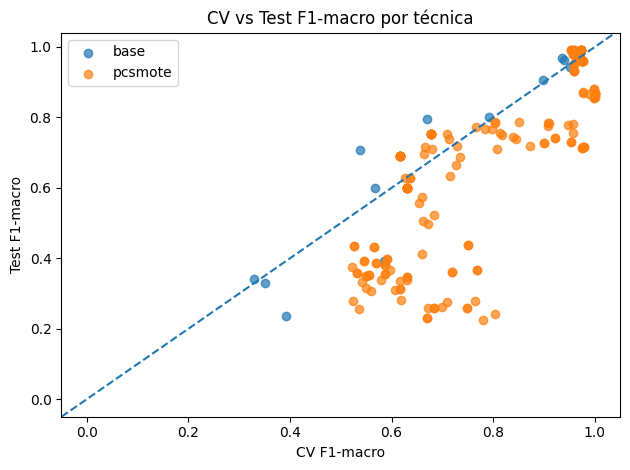

In [12]:
# ---------- Visualización: cv_f1_macro vs test_f1_macro ----------
import glob

archivos = glob.glob(os.path.join(dir_out, "resultados_*.csv"))
if archivos:
    dfs = []
    for f in archivos:
        try:
            d = pd.read_csv(f)
            d['modelo'] = os.path.splitext(os.path.basename(f))[0].replace("resultados_", "")
            dfs.append(d)
        except Exception:
            pass
    if dfs:
        todo = pd.concat(dfs, ignore_index=True)
        # Un scatter por técnica; podés filtrar si querés
        plt.figure()
        for tecnica, sub in todo.groupby('tecnica'):
            plt.scatter(sub['cv_f1_macro'], sub['test_f1_macro'], label=tecnica, alpha=0.7)
        plt.axline((0,0), slope=1, linestyle='--')  # línea y=x
        plt.xlabel('CV F1-macro'); plt.ylabel('Test F1-macro')
        plt.title('CV vs Test F1-macro por técnica')
        plt.legend()
        plt.tight_layout()
        plt.show()
